In [28]:
import numpy as np
import pandas as pd
import scanpy as sc
import scglue
import anndata as ad

import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns
import os
from itertools import cycle, chain

%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(4,4),dpi=120)

In [2]:
path = '/lustre/scratch/kiviaho/spatac/integrations/tonsilatlas/actual_scatac_to_spatial/'
os.chdir(path)

In [3]:
# DOWNLOAD DATA
rna = sc.read_h5ad('preprocessed_actual_spatial_rna_20221215.h5ad')
atac = sc.read_h5ad('preprocessed_simulated_spots_atac_20221215.h5ad')
glue = scglue.models.load_model('./results/glue-model-20221215.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

# Save the data structures with GLUE embeddings for plotting with squidpy (a different conda env !!)


[INFO] autodevice: Using CPU as computation device.


In [4]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)
combined = ad.concat([rna, atac])

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [5]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


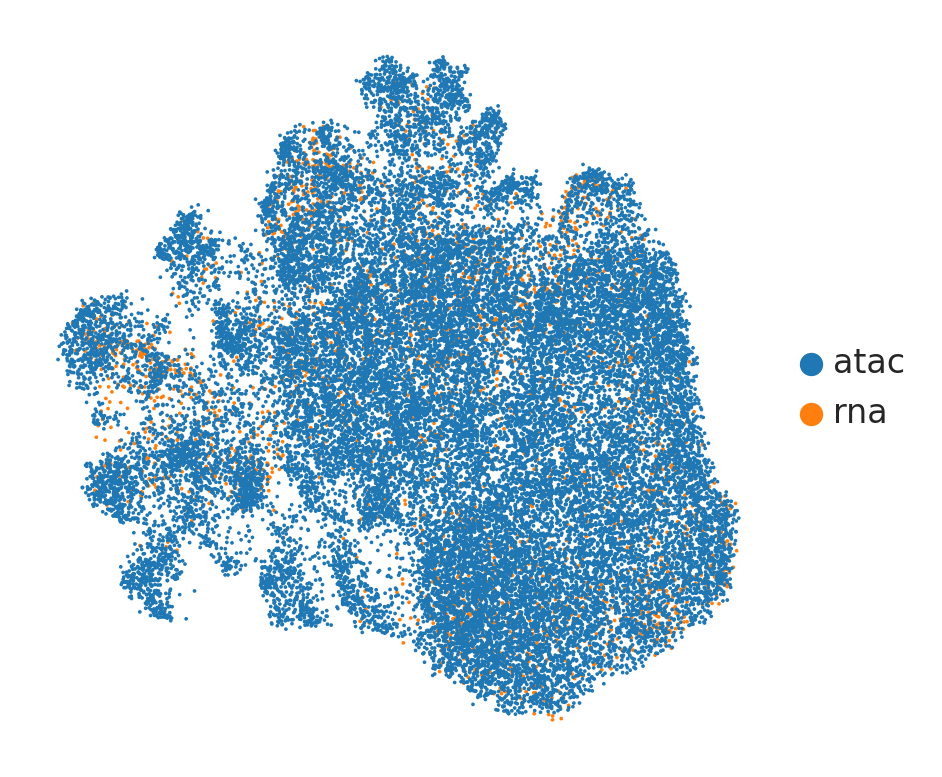

In [6]:
sc.pl.umap(combined, color=["domain"],s=5,legend_fontsize=10, frameon=False,title='',show=True)

In [7]:
rna

AnnData object with n_obs × n_vars = 3079 × 23514
    obs: 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'havana_gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_glue'
    varm: 'PCs'
    layers: 'counts'

## Find the nearest matches' cell type composition & peaks

In [8]:
sc_atac_reference = sc.read_h5ad('/lustre/scratch/kiviaho/spatac/data/atac_tonsil_scatac_BCLL10_T.h5ad')

In [9]:
sc_atac_reference

AnnData object with n_obs × n_vars = 3823 × 115526
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'GeneScores', 'X_svd', 'X_umap'
    obsp: 'connectivities', 'distances'

In [70]:
import time
n_neighbors = 7

start = time.time()
rna_glue = rna.obsm['X_glue']
atac_glue = atac.obsm['X_glue']

inferred_counts = np.empty((0,7),dtype=float)
summed_peaks = np.empty((0,atac.var.shape[0]),dtype=np.float32)

for a_idx in range(len(rna_glue)):
    # Repeats the same vector to match the size of atac_glue
    a = np.tile(rna_glue[a_idx],(atac_glue.shape[0],1))
    # Calculate the euclidean distance in GLUE space between each 'spot'
    distances = np.linalg.norm(a-atac_glue,axis=1)

    # Extract indices of n nearest matches
    nearest_matches = np.array(distances).argsort()[:n_neighbors]
    # Extract the cell counts and calculate their mean
    inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])

    # Extract the matched cell  barcodes and sum their scATAC peaks to get a peak reference
    #matching_bcodes_unformatted = atac[nearest_matches].obsm['cell_barcodes']['sampled_barcodes']
    #nested_list = [bcodes.split(',') for bcodes in matching_bcodes_unformatted] # This splits barcodes within each simulated spots
    #matching_bcodes = list(chain.from_iterable(nested_list)) # This unravels the nested structure
    #summed_peaks = np.vstack([summed_peaks,sc_atac_reference[matching_bcodes].X.sum(axis=0)])
    summed_peaks = np.vstack([summed_peaks,atac[nearest_matches].X.sum(axis=0)])
time.time() - start

/tmp/ipykernel_30060/3455278214.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
/tmp/ipykernel_30060/3455278214.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
/tmp/ipykernel_30060/3455278214.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(a

2217.7419440746307

In [78]:
inferred_spot_cell_counts = pd.DataFrame(inferred_counts, 
                             columns=atac.obs.columns[:inferred_counts.shape[1]],
                             index=rna.obs.index)
inferred_spot_cell_counts = np.round(inferred_spot_cell_counts)

In [84]:
inferred_atac_signal_for_spatial = sc.AnnData(X=summed_peaks,
obs=inferred_spot_cell_counts,
var=atac.var)

In [86]:
inferred_atac_signal_for_spatial.write_h5ad('./summed_atac_peaks_of_7_nearest_neigbors_of_real_spatial.h5ad')

In [87]:
2217/60

36.95